# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [5]:
# 4S Dsideband Data vs MC
columns = util.all_relevant_variables

# Load data files
MC_Dsb = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_4S_200fb_allD_korat_e_1/sig_*.root:B0'],
                          library="np",
                          #cut = '((D_M>1.79) & (D_M<1.82)) | ((D_M>1.92) & (D_M<1.95))',
                          filter_branch=lambda branch: branch.name in columns)

# data_Dsb = uproot.concatenate([f'../../Samples/Data/*4S_offres.root:B0'],
#                           library="np",
#                           cut = '((D_M>1.79) & (D_M<1.82)) | ((D_M>1.92) & (D_M<1.95))',
#                           filter_branch=lambda branch: branch.name in columns)

df_mc = pd.DataFrame(MC_Dsb)
# df_data = pd.DataFrame(data_Dsb)

In [6]:
samples=util.get_dataframe_samples_new(df_mc, 'e', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 38398
bkg_TDFl 1193
bkg_fakeTracks 382
bkg_continuum 1790
bkg_combinatorial 3123
bkg_singleBbkg 1801
bkg_other_TDTl 0
$D\tau\nu$ 1235
$D^\ast\tau\nu$ 615
$D\ell\nu$ 17645
$D^\ast\ell\nu$ 11425
$D^{\ast\ast}\tau\nu$ 372
$D^{\ast\ast}\ell\nu$ 6737
$D\ell\nu$_gap 1437
bkg_other_signal 0


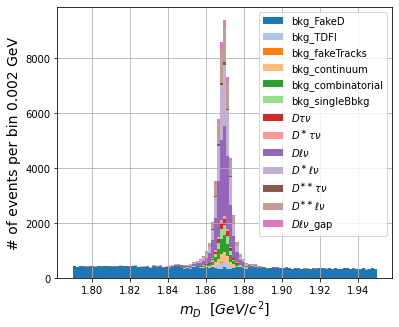

In [11]:
b1 = np.linspace(1.79,1.95,100)
mpl.plot_all_stacked(variable='D_M',bins=b1,cut=None,mask=[])
plt.title('')
plt.xlabel(r'$m_D$  $[GeV/c^2]$',fontsize=14)
plt.legend()

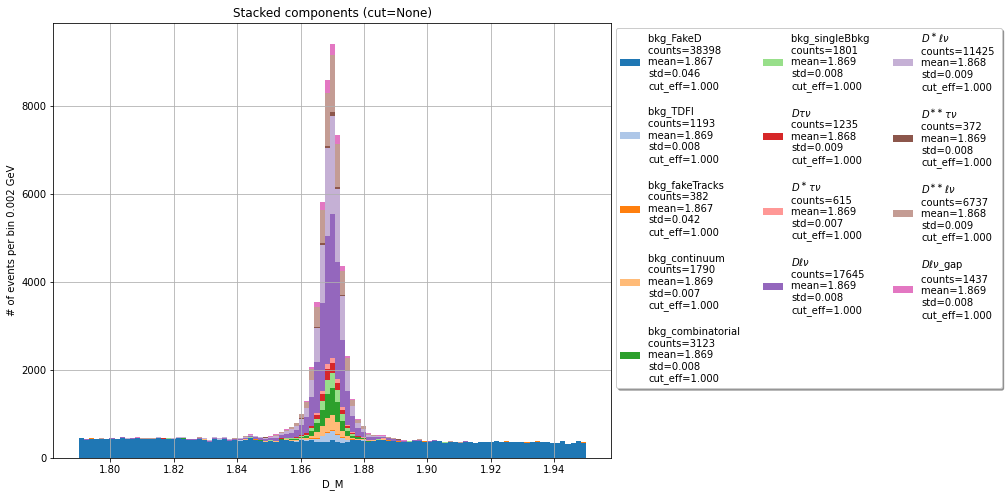

In [6]:
b1 = np.linspace(1.79,1.95,100)
mpl.plot_all_stacked(variable='D_M',bins=b1,cut=None,mask=[])
plt.title('')
plt.legend()

In [2]:
sig_input_cut = '(mode==0)'
LS_input_cut = '(D_M<1.84)'
RS_input_cut = '(D_M>1.9)'

columns = util.all_relevant_variables

# Load fake D from signal region
fakeD_sig = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/subset_*.root:B0'],
                          library="np",
                          cut=sig_input_cut,
                          filter_branch=lambda branch: branch.name in columns)

SBL = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/Dsideband/subset_*.root:B0'],
                          library="np",
                          cut=LS_input_cut,
                          filter_branch=lambda branch: branch.name in columns)

SBR = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/Dsideband/subset_*.root:B0'],
                          library="np",
                          cut=RS_input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_fakeD_sig = pd.DataFrame(fakeD_sig)
df_SBL = pd.DataFrame(SBL)
df_SBR = pd.DataFrame(SBR)
# templates=sample_classifier(df_temp)

In [12]:
from iminuit import cost, Minuit

def line(x, a, b):
    return a*x + b

bin_edges=np.linspace(1.79,1.95,100)

D_M_values = np.concatenate([df_fakeD_LS['D_M'], df_fakeD_sig['D_M'], df_fakeD_RS['D_M']])

count, bins = np.histogram(D_M_values, bins=bin_edges, density=False)

# Find indices where count is not equal to 0
non_zero_indices = np.where(count != 0)

# Filter both arrays based on non-zero indices
count_filtered = count[non_zero_indices]
bin_edges_filtered = bin_edges[non_zero_indices]

In [13]:
c = cost.LeastSquares(x = bin_edges_filtered, 
                      y = count_filtered, 
                      yerror = np.sqrt(count_filtered), 
                      model = line,
                      loss = 'soft_l1')

m = Minuit(c, a=-12000, b=31000)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 678.7 (chi2/ndof = 12.3)   │              Nfcn = 59               │
│ EDM = 3.02e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -13.44e3  │  0.24e3   │            │            │         │         │       │
│ 1 │ b    │  33.6e3   │   0.5e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  5.97e+04 -1.13e+05 │
│ b │ -1.13e+05  2.13e+05 │
└───┴─────────────────────┘

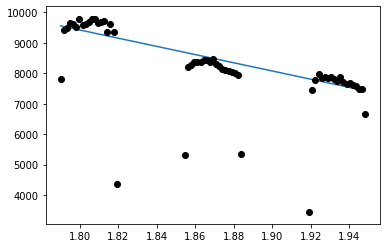

In [14]:
m.visualize()

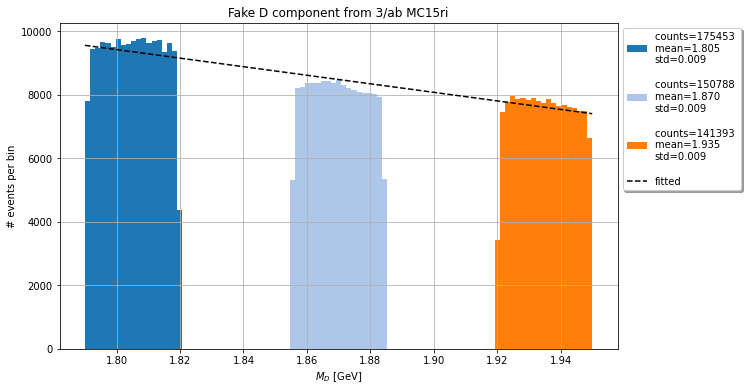

In [17]:
bin_edges=np.linspace(1.79,1.95,100)
plt.figure(figsize=(10, 6))
df_fakeD_LS.D_M.hist(bins=bin_edges, label=statistics(df_fakeD_LS.D_M))
df_fakeD_sig.D_M.hist(bins=bin_edges, label=statistics(df_fakeD_sig.D_M))
df_fakeD_RS.D_M.hist(bins=bin_edges, label=statistics(df_fakeD_RS.D_M))

y = line(bin_edges, a=m.values[0], b=m.values[1])
plt.plot(bin_edges, y, ls="--", label="fitted",color='black')
# plt.errorbar(bin_edges_filtered, count_filtered, np.sqrt(count_filtered), fmt="ok")

plt.title('Fake D component from 3/ab MC15ri')
plt.ylabel('# events per bin')
plt.xlabel('$M_D$ [GeV]')
plt.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1.5)

In [16]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''{counts=:d} \n{mean=:.3f} \n{std=:.3f}'''

In [18]:
def plot_sidebands_overlaid(variable,bins,cut=None,scale=None,shift=None):

    fig,axs =plt.subplots(sharex=True, sharey=False,figsize=(10, 6))
    dfs = [df_fakeD_LS, df_fakeD_sig, df_fakeD_RS]
    names = ['Left','Signal','Right']
    for i in range(len(names)):
        var_col = dfs[i][variable] if shift else dfs[i][variable]
        (counts, _) = np.histogram(var_col, bins=bins)
        kwarg={'histtype':'step','lw':2}

        axs.hist(bins[:-1], bins, weights=counts*scale[i] if scale else counts,
                label=f'{names[i]} \n{statistics(var_col)}',**kwarg)

    axs.set_title(f'Overlaid FakeD sideband + signal ({cut=})')
    axs.set_xlabel(f'{variable}')
    axs.set_ylabel('# of events per bin')
    axs.grid()
    plt.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1.5)
    
def plot_merged_sideband(variable,bins,cut=None,scale=None,shift=None):

    df_fakeD_LS['__weight__'] = scale[0]
    df_fakeD_RS['__weight__'] = scale[1]

    df_fakeD_side = pd.concat([df_fakeD_LS, df_fakeD_RS])

    fig,axs =plt.subplots(sharex=True, sharey=False,figsize=(10, 6))
    dfs = [df_fakeD_side, df_fakeD_sig]
    names = ['Sideband','Signal']
    for i in range(len(names)):
        var_col = dfs[i][variable] if shift else dfs[i][variable]
        (counts, _) = np.histogram(var_col, bins=bins,weights=dfs[i]['__weight__'])
        kwarg={'histtype':'step','lw':2}

        axs.hist(bins[:-1], bins, weights=counts,
                label=f'{names[i]} \n{statistics(var_col)} \n cut_eff={(len(var_col)/len(dfs[i])):.3f}',**kwarg)

    axs.set_title(f'Overlaid FakeD sideband + signal ({cut=})')
    axs.set_xlabel(f'{variable}')
    axs.set_ylabel(f'# of events per bin {(bins[1]-bins[0]):.3f} GeV')
    axs.grid()
    plt.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1.5)

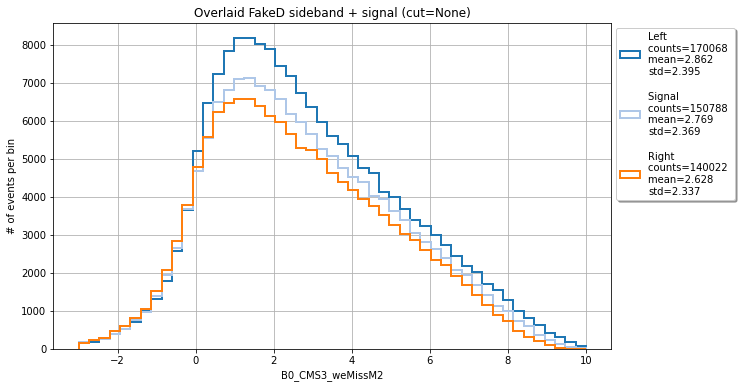

In [44]:
# sideband includes fake D only
b1 = np.linspace(-3,10,50)
plot_sidebands_overlaid(variable='B0_CMS3_weMissM2',bins=b1) 

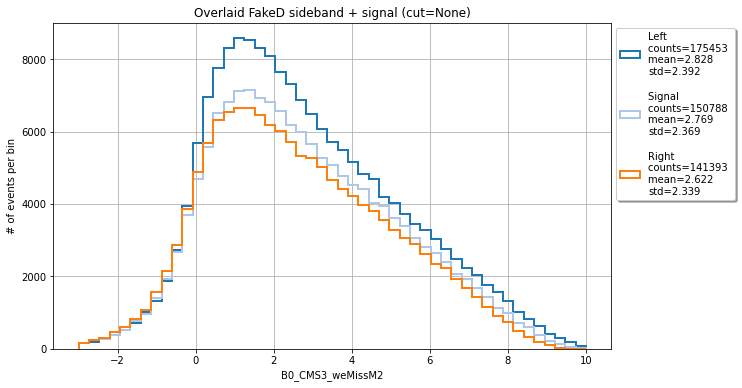

In [19]:
# sideband includes all components
b1 = np.linspace(-3,10,50)
plot_sidebands_overlaid(variable='B0_CMS3_weMissM2',bins=b1)

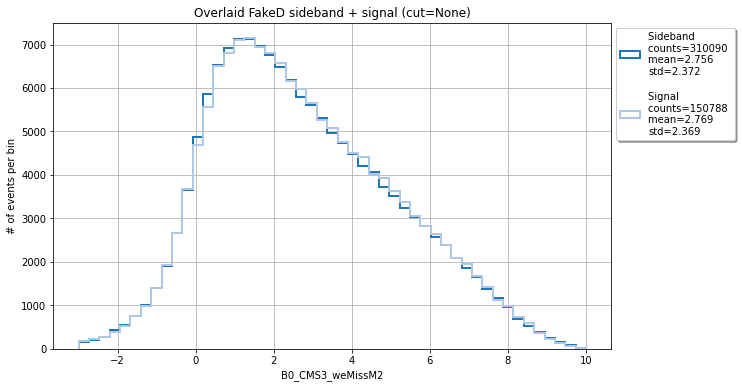

In [9]:
b1 = np.linspace(-3,10,50)
plot_merged_sideband(variable='B0_CMS3_weMissM2',bins=b1,scale=[15/34, 15/28])

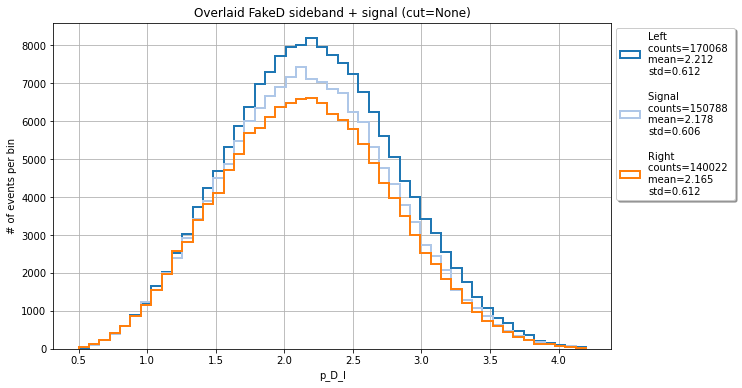

In [46]:
b2 = np.linspace(0.5,4.2,50)
plot_sidebands_overlaid(variable='p_D_l',bins=b2)

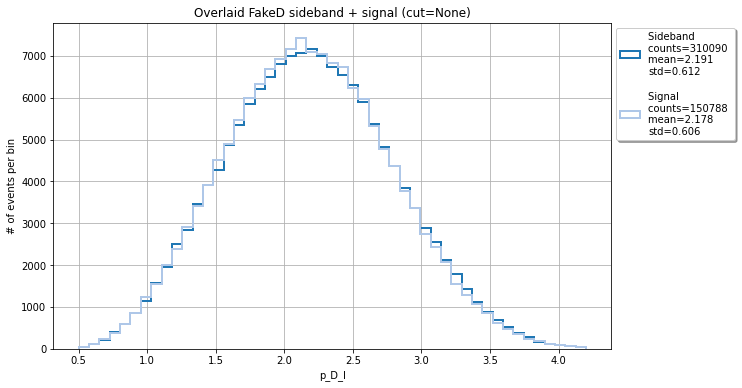

In [10]:
b2 = np.linspace(0.5,4.2,50)
plot_merged_sideband(variable='p_D_l',bins=b2,scale=[15/34, 15/28])

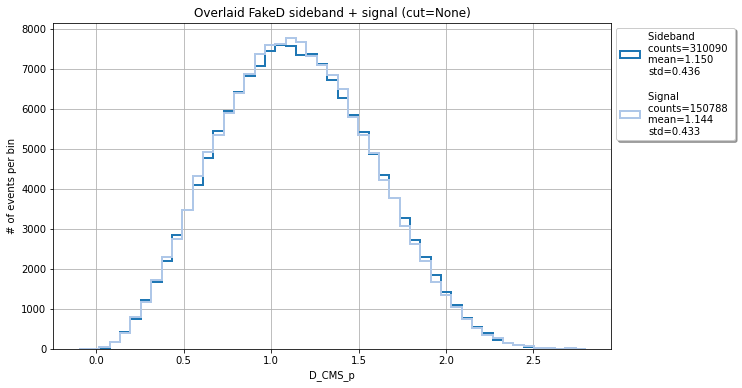

In [13]:
b1 = np.linspace(-0.1,2.8,50)
plot_merged_sideband(variable='D_CMS_p',bins=b1,scale=[15/34, 15/28])

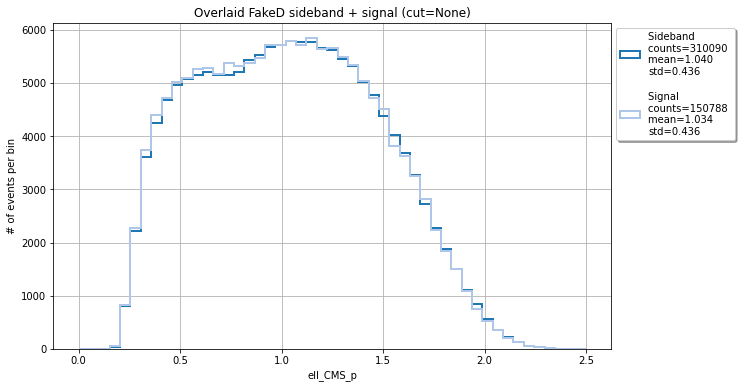

In [11]:
b1 = np.linspace(0,2.5,50)
plot_merged_sideband(variable='ell_CMS_p',bins=b1,scale=[15/34, 15/28])

In [ ]:
def plot_hist_2d(sample, name, variables=['B0_CMS3_weMissM2','p_D_l'], cut=None):
        variable_x, variable_y = variables
        xedges = np.linspace(-7, 11, 30)
        if variables[1]=='p_D_l':
            yedges = np.linspace(0, 5, 20)
        elif variables[1]=='B_CMS_E':
            yedges = np.linspace(1.4, 5.6, 42)
        
        
        fig = plt.figure(figsize=[8,6])
        sample_size = len(sample.query(cut)) if cut else len(sample)

        ax = fig.add_subplot(1,1,1)
        (counts, xedges, yedges) = np.histogram2d(
                        sample.query(cut)[variable_x] if cut else sample[variable_x], 
                        sample.query(cut)[variable_y] if cut else sample[variable_y],
                        bins=[xedges, yedges])
        counts = counts.T

        mask_arr = np.ones_like(counts)


        X, Y = np.meshgrid(xedges, yedges)
        im=ax.pcolormesh(X, Y, counts, cmap='rainbow', norm=colors.LogNorm(), alpha=mask_arr)
        ax.grid()
        ax.set_xlim(xedges.min(),xedges.max())
        ax.set_ylim(yedges.min(),yedges.max())
        ax.set_title(name,fontsize=14)
        fig.colorbar(im,ax=ax)
        ax.set_title(name,fontsize=14)

        fig.supylabel('$|p_D|\ +\ |p_l|\ \ \ [GeV]$', x=0.03,fontsize=18)
        fig.supxlabel('$M_{miss}^2\ \ \ [GeV^2/c^4]$', y=0.02,fontsize=18)
        

In [7]:
fakeK = df_fakeTrack.query('D_K_mcErrors==512')
fakePi1 = df_fakeTrack.query('D_pi1_mcErrors==512')
fakePi2 = df_fakeTrack.query('D_pi2_mcErrors==512')

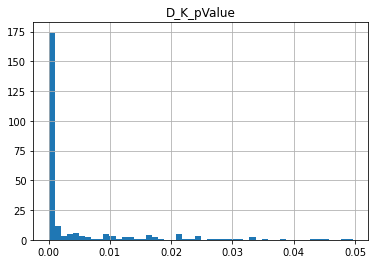

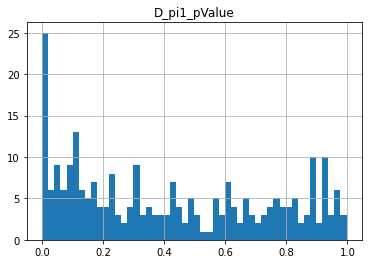

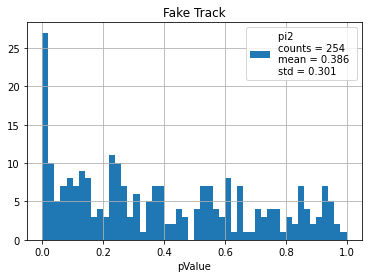

In [14]:
fakeK.hist(column='D_K_pValue',bins=50,label='K \n'+statistics(fakeK['D_K_pValue']))
fakeK.hist(column='D_pi1_pValue',bins=50,label='pi1 \n'+statistics(fakeK['D_pi1_pValue']))
fakeK.hist(column='D_pi2_pValue',bins=50,label='pi2 \n'+statistics(fakeK['D_pi2_pValue']))
plt.title('Fake Track')
#plt.xlim(-6,10)
plt.xlabel('pValue')
plt.legend()

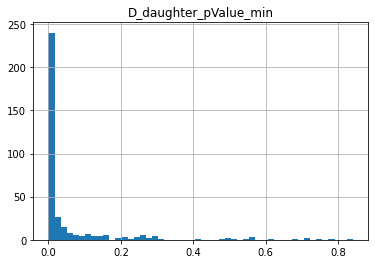

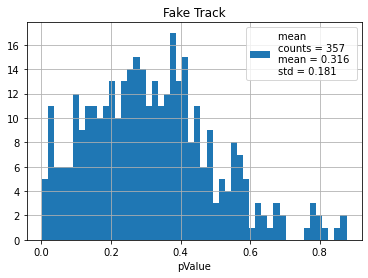

In [8]:
fakeK.hist(column='D_daughter_pValue_min',bins=50,label='min \n'+statistics(fakeK['D_daughter_pValue_min']))
fakeK.hist(column='D_daughter_pValue_mean',bins=50,label='mean \n'+statistics(fakeK['D_daughter_pValue_mean']))
plt.title('Fake Track')
#plt.xlim(-6,10)
plt.xlabel('pValue')
plt.legend()

# 2. Plot

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', variables=['B0_CMS3_weMissM2','B_CMS_E'],mask=None)

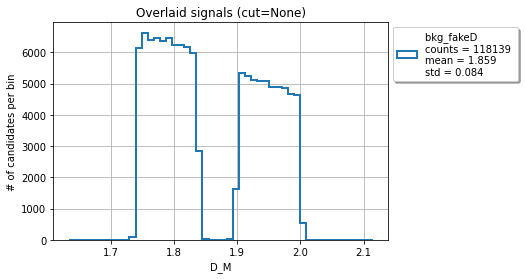

In [14]:
mpl.plot_all_overlaid(variable='D_M',cut=None,
                      mask=['bkg_fakeTC', 'bkg_combinatorial', 'bkg_Odecay',
                            r'$D\tau\nu$',r'$D\ell\nu$',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
#plt.xlim(1.84,1.9)

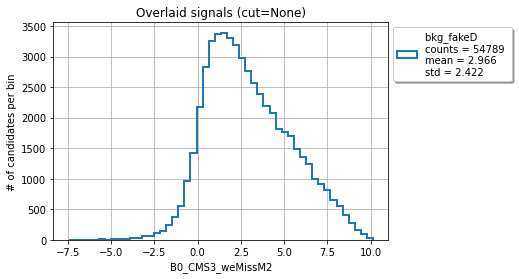

In [22]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,
                      mask=['bkg_fakeTC', 'bkg_combinatorial', 'bkg_Odecay',
                            r'$D\tau\nu$',r'$D\ell\nu$',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
#plt.xlim(1.84,1.9)

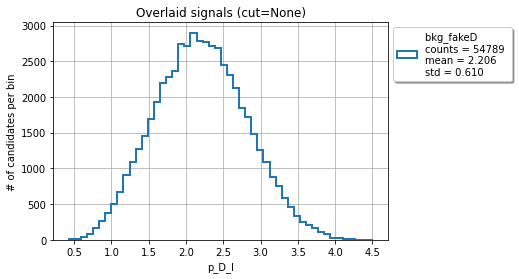

In [23]:
mpl.plot_all_overlaid(variable='p_D_l',cut=None,
                      mask=['bkg_fakeTC', 'bkg_combinatorial', 'bkg_Odecay',
                            r'$D\tau\nu$',r'$D\ell\nu$',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
#plt.xlim(1.84,1.9)

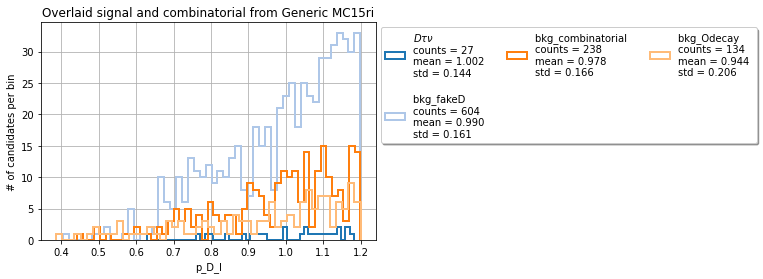

In [19]:
mpl.plot_all_overlaid(variable='p_D_l',cut='B0_CMS3_weMissM2>2.5 and cos_D_l>0.5 and p_D_l<1.2',
                      mask=['bkg_fakeTC',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
# plt.xlabel('$|p^{CMS}_D| + |p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal and combinatorial from Generic MC15ri');

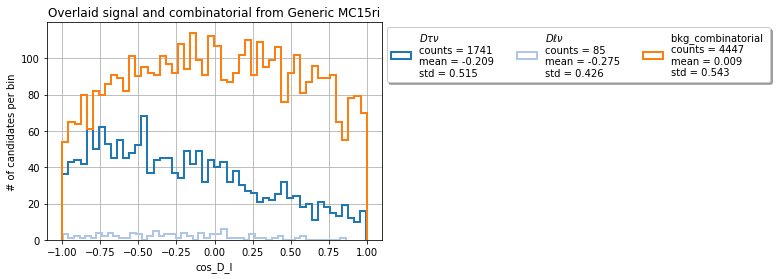

In [11]:
mpl.plot_all_overlaid(variable='cos_D_l',cut='B0_CMS3_weMissM2>2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_fakeTC',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
# plt.xlabel('$|p^{CMS}_D| + |p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal and combinatorial from Generic MC15ri');

In [ ]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlabel('$M^2_{miss} \ \ [GeV^2/c^4]$')
plt.title('Overlaid signal MC (different components are scaled)');

In [ ]:
mpl.plot_signals_overlaid(variable='B0_CMS3_weMissM2',cut='p_D_l<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_cut_efficiency(cut='signal_prob==largest_prob and signal_prob>0.8', variable='B0_CMS3_weQ2lnuSimple')

In [ ]:
mpl.plot_all_separately(variable='B0_CMS3_weQ2lnuSimple',xlim=[-2,13])